In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"klyushnik","key":"0383b36da64c3f3356fff0affef42621"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c nlp-getting-started

  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 61.9MB/s]


In [ ]:
! unzip nlp-getting-started.zip

Archive:  nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
import numpy as np 
import pandas as pd 
from sklearn import feature_extraction, linear_model, model_selection, preprocessing

In [ ]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

In [ ]:
train[train["target"] == 0]["text"].values[1]

'I love fruits'

In [ ]:
train[train["target"] == 1]["text"].values[1]

'Forest fire near La Ronge Sask. Canada'

In [ ]:
count_vectorizer = feature_extraction.text.CountVectorizer()


example_train_vectors = count_vectorizer.fit_transform(train["text"][0:5])

In [ ]:
print(example_train_vectors[0].todense().shape)
print(example_train_vectors[0].todense())

(1, 54)
[[0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0
  0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0]]


In [ ]:
train_vectors = count_vectorizer.fit_transform(train["text"])

## note that we're NOT using .fit_transform() here. Using just .transform() makes sure
# that the tokens in the train vectors are the only ones mapped to the test vectors - 
# i.e. that the train and test vectors use the same set of tokens.
test_vectors = count_vectorizer.transform(test["text"])

In [ ]:
clf = linear_model.RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, random_state=None,
                solver='auto', tol=0.001)

In [ ]:
scores = model_selection.cross_val_score(clf, train_vectors, train["target"], cv=3, scoring="roc_auc")
scores

array([0.74041555, 0.68319257, 0.77356695])

In [ ]:
clf.fit(train_vectors, train["target"])

RidgeClassifier()

In [ ]:
sample_submission = pd.read_csv("sample_submission.csv")

In [ ]:
sample_submission["target"] = clf.predict(test_vectors)

In [ ]:
sample_submission.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,1


In [ ]:
sample_submission.to_csv("submission.csv", index=False)

In [ ]:
! kaggle competitions submit -c nlp-getting-started -f submission.csv -m "Message"

100% 22.2k/22.2k [00:00<00:00, 46.0kB/s]
Successfully submitted to Natural Language Processing with Disaster Tweets

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
test_df = pd.read_csv('test.csv')
train_df = pd.read_csv('train.csv')

In [ ]:
train_df_shuffled = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
train_df_shuffled.head()

,id,keyword,location,text,target
0,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
1,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
2,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
3,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
4,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = (
    train_test_split(train_df_shuffled["text"].to_numpy(),
                     train_df_shuffled["target"].to_numpy(),
                     test_size=0.1,
                     random_state=42)
)

len(X_train), len(X_test), len(y_train), len(y_test)

(6851, 762, 6851, 762)

In [ ]:
from tensorflow.keras import models, layers, callbacks
from tensorflow.keras.optimizers import Adam

BATCH_SIZE = 32

def prepare(ds, shuffle=False):
    
    # Applying normalization before `ds.cache()` to re-use it.
    # Note: Random transformations (e.g. images augmentations) should be applied
    # after both `ds.cache()` (to avoid caching randomness) and `ds.batch()` (for
    # vectorization [1]).

    if shuffle:
        ds = ds.shuffle(buffer_size=1000)

    # Batch after shuffling to get unique batches at each epoch.
    ds = ds.batch(BATCH_SIZE)
    ds = ds.cache() 

    return ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_data = prepare(train_data, shuffle=True)

test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_data = prepare(test_data)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tdidf", TfidfVectorizer()),
    ("model", MultinomialNB())  
])

model_0.fit(X_train,y_train)

Pipeline(steps=[('tdidf', TfidfVectorizer()), ('model', MultinomialNB())])

In [ ]:
baseline_score = model_0.score(X_test,y_test)
print(f"Baseline score: {baseline_score*100:.2f}%")

Baseline score: 79.27%


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.
  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array
  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [ ]:
y_pred = model_0.predict(X_test)
baseline_results = calculate_results(y_true=y_test, y_pred=y_pred)
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy='mixed_float16')
mixed_precision.global_policy()

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


<Policy "mixed_float16">

In [ ]:
import tensorflow_hub as hub

USE5_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5"

encoder_layer = hub.KerasLayer(
    USE5_url,
    output_shape=[],
    dtype=tf.string,
    trainable=False,
    name="USE"
)

In [ ]:
model = models.Sequential([
    layers.Input(shape=[], dtype=tf.string),
    encoder_layer,
    layers.Dense(128, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(64, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1),
    layers.Activation("sigmoid", dtype=tf.float32)
], name="model_USE")


model.compile(optimizer=Adam(learning_rate=2.5e-4),
                loss="binary_crossentropy",
                metrics=["accuracy"])
model.summary()

Model: "model_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               147354880 
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                         

In [ ]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

USE False string <Policy "string">
dense True float32 <Policy "mixed_float16">
batch_normalization True float32 <Policy "mixed_float16">
dropout True float32 <Policy "mixed_float16">
dense_1 True float32 <Policy "mixed_float16">
batch_normalization_1 True float32 <Policy "mixed_float16">
dropout_1 True float32 <Policy "mixed_float16">
dense_2 True float32 <Policy "mixed_float16">
activation True float32 <Policy "float32">


In [ ]:
stop_callback = callbacks.EarlyStopping(monitor="val_loss",
                                        patience=3)

lr_callback = callbacks.ReduceLROnPlateau(monitor="val_loss",
                                          factor=0.5,
                                          patience=2,
                                          verbose=1,
                                          min_lr=1e-7)

checkpoint_callback = callbacks.ModelCheckpoint('saved_models/disaster',
                                                monitor='val_accuracy',
                                                save_best_only=True)

history_model = model.fit(train_data,
                          epochs=100,
                          validation_data=(test_data),
                          callbacks=[stop_callback, lr_callback, checkpoint_callback])

Epoch 1/100
215/215 [==============================] - ETA: 0s - loss: 0.7321 - accuracy: 0.6536INFO:tensorflow:Assets written to: saved_models/disaster/assets


INFO:tensorflow:Assets written to: saved_models/disaster/assets


215/215 [==============================] - 257s 1s/step - loss: 0.7321 - accuracy: 0.6536 - val_loss: 0.6362 - val_accuracy: 0.5669 - lr: 2.5000e-04
Epoch 2/100
215/215 [==============================] - ETA: 0s - loss: 0.5586 - accuracy: 0.7510INFO:tensorflow:Assets written to: saved_models/disaster/assets


INFO:tensorflow:Assets written to: saved_models/disaster/assets


215/215 [==============================] - 174s 813ms/step - loss: 0.5586 - accuracy: 0.7510 - val_loss: 0.4943 - val_accuracy: 0.7730 - lr: 2.5000e-04
Epoch 3/100
215/215 [==============================] - ETA: 0s - loss: 0.5171 - accuracy: 0.7686INFO:tensorflow:Assets written to: saved_models/disaster/assets


INFO:tensorflow:Assets written to: saved_models/disaster/assets


215/215 [==============================] - 175s 815ms/step - loss: 0.5171 - accuracy: 0.7686 - val_loss: 0.4249 - val_accuracy: 0.8189 - lr: 2.5000e-04
Epoch 4/100
215/215 [==============================] - ETA: 0s - loss: 0.4833 - accuracy: 0.7867INFO:tensorflow:Assets written to: saved_models/disaster/assets


INFO:tensorflow:Assets written to: saved_models/disaster/assets


215/215 [==============================] - 183s 851ms/step - loss: 0.4833 - accuracy: 0.7867 - val_loss: 0.4222 - val_accuracy: 0.8241 - lr: 2.5000e-04
Epoch 5/100
215/215 [==============================] - ETA: 0s - loss: 0.4569 - accuracy: 0.8054INFO:tensorflow:Assets written to: saved_models/disaster/assets


INFO:tensorflow:Assets written to: saved_models/disaster/assets


215/215 [==============================] - 178s 829ms/step - loss: 0.4569 - accuracy: 0.8054 - val_loss: 0.4232 - val_accuracy: 0.8268 - lr: 2.5000e-04
Epoch 6/100
215/215 [==============================] - 105s 490ms/step - loss: 0.4346 - accuracy: 0.8148 - val_loss: 0.4206 - val_accuracy: 0.8255 - lr: 2.5000e-04
Epoch 7/100
215/215 [==============================] - 109s 509ms/step - loss: 0.4207 - accuracy: 0.8174 - val_loss: 0.4202 - val_accuracy: 0.8189 - lr: 2.5000e-04
Epoch 8/100
215/215 [==============================] - 108s 504ms/step - loss: 0.4093 - accuracy: 0.8279 - val_loss: 0.4214 - val_accuracy: 0.8202 - lr: 2.5000e-04
Epoch 9/100
215/215 [==============================] - ETA: 0s - loss: 0.4032 - accuracy: 0.8272
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
215/215 [==============================] - 109s 505ms/step - loss: 0.4032 - accuracy: 0.8272 - val_loss: 0.4228 - val_accuracy: 0.8202 - lr: 2.5000e-04
Epoch 10/100
215/215 [=========

In [ ]:
model_preds_prob = model.predict(X_test)
model_preds = model_preds_prob.round().squeeze()
model_preds[:10]

array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)

In [ ]:
model_results = calculate_results(y_test,model_preds)
model_results

{'accuracy': 82.02099737532808,
 'f1': 0.8188242643827762,
 'precision': 0.8223219905078891,
 'recall': 0.8202099737532809}

In [ ]:
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(baseline_results,model_results)

Baseline accuracy: 79.27, New accuracy: 82.02, Difference: 2.76
Baseline precision: 0.81, New precision: 0.82, Difference: 0.01
Baseline recall: 0.79, New recall: 0.82, Difference: 0.03
Baseline f1: 0.79, New f1: 0.82, Difference: 0.03


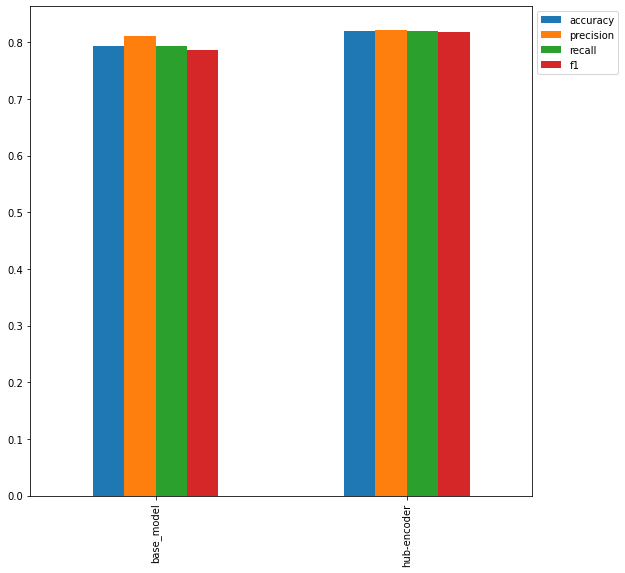

In [ ]:
all_results = pd.DataFrame({
    "base_model": baseline_results,
    "hub-encoder": model_results
})
all_results = all_results.transpose()
all_results["accuracy"] = all_results["accuracy"]/100
all_results.plot(kind="bar", figsize=(9,9)).legend(bbox_to_anchor=(1., 1))

Text(0.5, 1.0, 'f1-score')

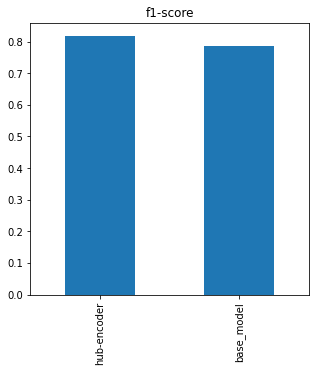

In [ ]:
all_results.sort_values(by="f1", ascending=False)["f1"].plot(kind="bar", figsize=(5,5)).set_title("f1-score")

In [ ]:
test_data = test_df.text.values
test_pred = model.predict(test_data)

In [ ]:
submission_df = pd.DataFrame({
    "id": test_df.id,
    "target": test_pred.round().squeeze().astype(np.int64)
})

In [ ]:
submission_df.to_csv("submission.csv", index=False)

In [ ]:
 ! kaggle competitions submit -c nlp-getting-started -f submission.csv -m "Message"

100% 22.2k/22.2k [00:00<00:00, 47.2kB/s]
Successfully submitted to Natural Language Processing with Disaster Tweets